# Preparation

In [ ]:
!pip install d2l

In [ ]:
!pip install matplotlib==3.1.3

# Sentiment Analysis and the Dataset

In [3]:
import os
import torch
from torch import nn
from d2l import torch as d2l

Reading the dataset

In [4]:
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [5]:
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Two years passed and mostly everyone looks different, some f
label: 1 review: This show is beautifully done. When it first came out I thou
label: 1 review: Wow... 5 more hours of Riget. Lars continues the great combi


Preprocessing

filtering out words tha appear less than 5 times, create vocab

In [8]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <a list of 19 Patch objects>)

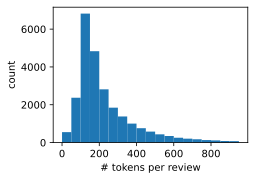

In [9]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [10]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


Creating data iterators

In [11]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


Putting all things together

In [12]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

# Sentiment Analysis: Using Recurrent Neural Networks

GloVe + RNN

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

Representing single text with RNNs

In [14]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

In [15]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

Loading pre-trained word vectors

In [16]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [17]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [18]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

Training and evaluating the model

loss 0.263, train acc 0.892, test acc 0.856
277.8 examples/sec on [device(type='cuda', index=0)]


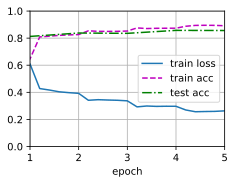

In [19]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [20]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    print(sequence)
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [21]:
predict_sentiment(net, vocab, 'this movie is so great')

tensor([10, 20,  6, 39, 94], device='cuda:0')


'positive'

In [22]:
predict_sentiment(net, vocab, 'this movie is so bad')

tensor([10, 20,  6, 39, 98], device='cuda:0')


'negative'

In [23]:
predict_sentiment(net, vocab, 'the characters are good but the plot sucks')

tensor([   1,  125,   21,   52,   17,    1,  136, 4014], device='cuda:0')


'negative'

# Sentiment Analysis: Using Convolutional Neural Networks

GloVe + CNN

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [25]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [26]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [27]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

***max-over-time pooling***: extract the highest value from sequence representatons as the most important feature across time steps.

textCNN model

In [28]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [29]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

Loading pretrained word vectors

In [30]:
love_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.064, train acc 0.979, test acc 0.876
1139.3 examples/sec on [device(type='cuda', index=0)]


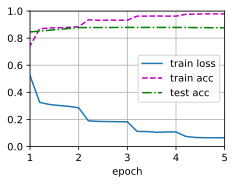

In [31]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [32]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [33]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [34]:
d2l.predict_sentiment(net, vocab, 'the characters are great but the plot is bad')

'positive'

# Natural Language Inference and the Dataset

In [35]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

Reading dataset

In [36]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [37]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [38]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [39]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

Putting all things together

In [40]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [41]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


18678

In [42]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


# Natural Language Inference: Using Attention

GloVe + MLP & Attention

attend + compare + aggregate + prediction

In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [45]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [47]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [48]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [49]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [50]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

Training and Evaluating

In [51]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [52]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2871, -0.5999,  0.4688,  ...,  0.3639, -0.8138, -0.2211],
        [ 0.9682,  0.0718,  0.1710,  ...,  0.1024,  1.3345, -0.4854],
        [ 0.1964,  0.0332,  0.1263,  ...,  0.1077,  0.0260,  0.8928]])

loss 0.498, train acc 0.805, test acc 0.828
6382.0 examples/sec on [device(type='cuda', index=0)]


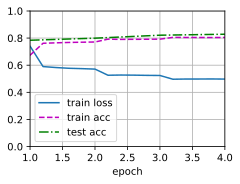

In [53]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [54]:
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [55]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

# Fine-tuning Bert for sequence-level and token-level applications

# Natural Language Inference: Fine-Tuning Bert

Bert + MLP

In [56]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [57]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [58]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [59]:
evices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [60]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [62]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Self-study

In [ ]:
!pip install transformers

In [69]:
from transformers import AutoModel
from torch import nn
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
import torch


class Task1Baseline(nn.Module):
    def __init__(self):
        super(Task1Baseline, self).__init__()

        self.num_classes = 2
        self.bert = AutoModel.from_pretrained('roberta-base', return_dict=False, output_hidden_states=True)
        self.dropout = nn.Dropout(0.1) # TODO: confirm dropout prob

        self.classifier = nn.Linear(768, self.num_classes)


    def forward(self, input_ids, attention_mask, labels, class_weight):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1] # shape=(batch_size, 768)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss_fct = CrossEntropyLoss(class_weight)
        loss = loss_fct(logits, labels)


        return logits, loss

In [70]:
model = Task1Baseline()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
model

Task1Baseline(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [78]:
for param in model.bert.parameters():
  print(param.shape)

torch.Size([50265, 768])
torch.Size([514, 768])
torch.Size([1, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size